To calibrate pod for work:
1. Launcher -> Terminal
2. Create virtual environment: 
    python -m venv venv --system-site-packages
3. Then activate virtual environment:  Can all of this be done with a transported setup file?
    * cd venv
    * source bin/activate
    * pip install --upgrade pip 
    * python -m ipykernel install --user --name=venv (name=huggingface) 
4. Create new notebook (python 3) with launcher '+' (beside terminal tab)
    * Select the name of your virtual environment
5. Install source requirements into venv:
    pip freeze > requirements.txt
    mv requirements.txt venv
    pip install -r requirements.txt
6. install packages in terminal: (update list as needed)
    * pip install datasets transformers

~ 15 minutes of time to install (nearly not worth redoing each time a runpod is started)
pip freeze > requirements.txt
mv requirements.txt venv
pip install -r requirements.txt
pip install datasets transformers

___
To Transfer Files from RunPod:
1. Run the following in bash:
   runpodctl send transfer_test.csv (have virtual_env as your cd)
2. Then, locally run:
   runpodctl receive (code)
3. If this fails, Try alternatives (Have prompt for Claude prepared)
   https://docs.runpod.io/pods/storage/transfer-files

In [8]:
import torch
from datasets import load_dataset
from transformers import pipeline

%config InteractiveShell.ast_node_interactivity = 'all'

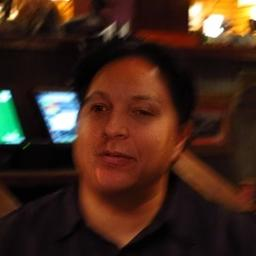

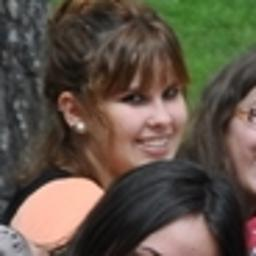

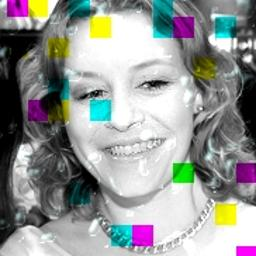

In [9]:
import ipywidgets as widgets
from IPython.display import display

image_dt = load_dataset("Whab/deepfake").shuffle(seed=12); 

preview_num = 3
sample_images = image_dt['train'][0:preview_num]
## Preview Images
for i in range(preview_num):
    display(sample_images['image'][i]) 

In [10]:
import time

#deepfake_detection = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device='cuda', use_fast=True)
deepfake_detection = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True);  

num_test = 100

start = time.time()
# Model inference  # 20-40 seconds locally
results = deepfake_detection(image_dt['train'][0:num_test]['image'])
end = time.time() - start
print('Inference Time:', end)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Inference Time: 19.79550075531006


In [ ]:
# performance of model prior to inferring on full dataset
import pandas as pd
import numpy as np

res = pd.DataFrame()
for i in range(len(results)):
    join = pd.DataFrame({'label': [results[i][1]['label']], 'score': [round(results[i][1]['score'], 5)]})
    res = pd.concat([res, join])

# Simplify to only give 'real' probabilities 
res = res.reset_index(drop=True)
res['y_hat'] = np.where(res.label == 'Fake', 1 - res.score, res.score)
res['label'] = np.where(res.label == 'Fake', 'Real', res.label)

# Add true labels and error terms
res['y_true'] = image_dt['train'][0:num_test]['label']
res['error'] = abs(res['y_true'] - res['y_hat']).round(6)
res.head(10)


,label,score,y_hat,y_true,error
0,Real,0.01765,0.01765,0,0.01765
1,Real,0.03880,0.96120,1,0.03880
2,Real,0.01796,0.01796,0,0.01796
3,Real,0.01737,0.01737,0,0.01737
4,Real,0.02855,0.02855,0,0.02855
5,Real,0.09033,0.90967,1,0.09033
6,Real,0.01863,0.01863,0,0.01863
7,Real,0.02866,0.97134,1,0.02866
8,Real,0.02410,0.97590,1,0.02410
9,Real,0.02327,0.02327,0,0.02327


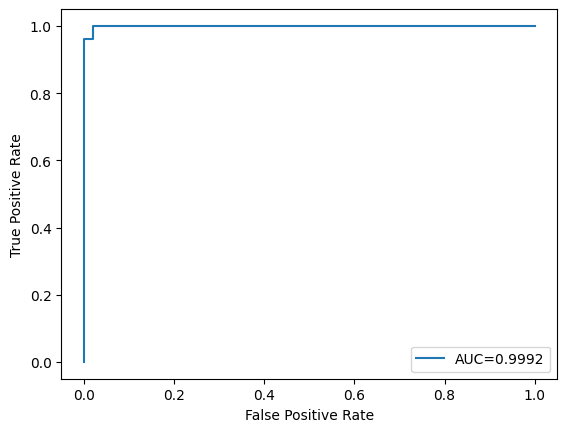

In [12]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math 

fpr, tpr, threshold = metrics.roc_curve(res['y_true'], res['y_hat'])
roc_auc = metrics.auc(fpr, tpr)

# ROC curve with AUC
plt.plot(fpr,tpr,label='AUC='+str(round(roc_auc, 5)));  
plt.ylabel('True Positive Rate');  
plt.xlabel('False Positive Rate');  
plt.legend(loc=4);  
plt.show();  


<Axes: >

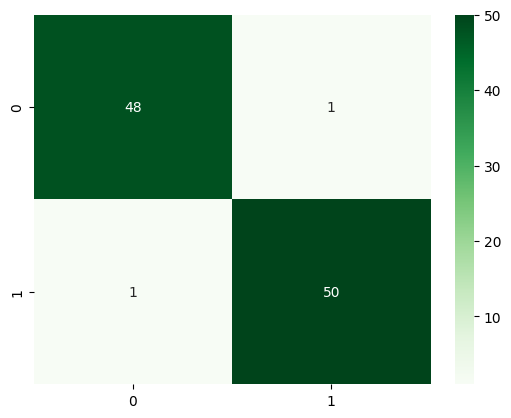

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Get optimal threshold
transform_threshold = [0] * len(threshold)
for i in range(len(threshold)):
    transform = ([1]-fpr[i])**2 + tpr[i]**2
    transform_threshold[i] = math.sqrt(transform);  

transform_threshold = np.array(transform_threshold);  
max_thresh = threshold[transform_threshold.argmax(axis=0)]

res['y_pred'] = np.where(res['y_hat'] > max_thresh, 1, 0)

cm = confusion_matrix(res['y_true'], res['y_pred'], labels=None);  
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens');  
plt.show()

<Axes: xlabel='error', ylabel='Count'>

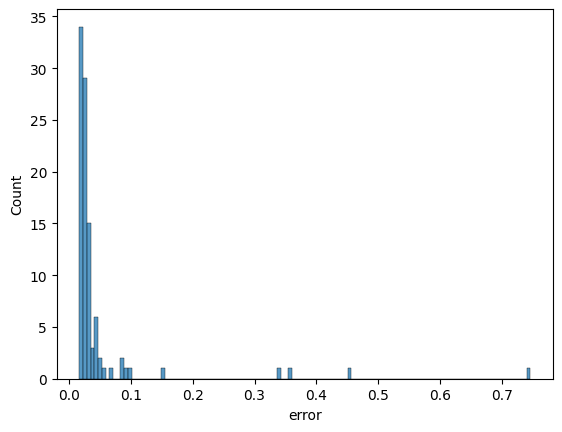

In [ ]:
import seaborn as sns
# dist'n of errors
err_dist = sns.histplot(data=res, x='error')
err_dist  


In [ ]:
###  code to infer several pipelines

import time
#models = ["prithivMLmods/Deep-Fake-Detector-Model", "joyc360/deepfakes"]
deepfake_detection_1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device='cuda', use_fast=True)
deepfake_detection_2 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True)

start = time.time()
res_dd1 = deepfake_detection_1(image_dt['train'][0:num_test]['image'])
end1 = time.time() - start
print('dd1 completed in:', end1)
res_dd2 = deepfake_detection_2(image_dt['train'][0:num_test]['image'])
end2 = time.time() - end1
print('dd2 completed in:', end2)

In [ ]:
### Future steps
# Automate Performance stats and result for multiple models
# Consider additional datasets

